In [1]:
from dotenv import load_dotenv

In [2]:

load_dotenv()


True

In [4]:
from ml_models_creation import create_and_write_logistic_model_to_file

In [5]:
from ml_models_creation import get_data

In [6]:
from app.settings import TinkoffSettings

In [7]:
from app.tinkoff_service import TkBroker

In [9]:
tk_broker = TkBroker(tok=TinkoffSettings().tk_api_key)

In [89]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [145]:
create_and_write_logistic_model_to_file(
    ticker="GAZP",
    days=15,
    data_folder=".",
    model=LogisticRegressionCV(max_iter=10000, class_weight="balanced"),
    offset_days=1
)


len of data for GAZP - 2197
action
BUY        1151
SELL        829
NOTHING     217
Name: count, dtype: int64


In [146]:
from app.settings import StrategySettings
from ta import add_all_ta_features
import pandas as pd
from tinkoff.invest import CandleInterval
from ml_models_creation import get_workday_time_ranges_last_days, get_actions


def get_data(
    ticker: str,
    days: int,
    offset_days: int = 0,
):
    tk_broker = TkBroker(tok=TinkoffSettings().tk_api_key)
    if not tk_broker.validate_tickers(stock_tickers=[ticker]):
        return

    dfs = []
    for start_day, end_day in get_workday_time_ranges_last_days(days=days, offset_days=offset_days):
        dfs.append(
            tk_broker.get_candles_from_ticker(
                ticker=ticker,
                from_=start_day,
                to_=end_day,
                candl_interval=CandleInterval.CANDLE_INTERVAL_5_MIN
            )
        )
    df = pd.concat(dfs)

    all_df = add_all_ta_features(
        df,
        open="open",  # noqa
        high="high",
        low="low",
        close="close",
        volume="volume"
    )

    all_df = all_df.drop("trend_psar_up", axis=1)
    all_df = all_df.drop("trend_psar_down", axis=1)
    all_df = all_df.dropna()

    all_df["action"] = get_actions(
        stop_loss_percent=StrategySettings().stopp_loss_percent,
        take_profit_percent=StrategySettings().profit_percent,
        prices=all_df["close"],
        lows=all_df["low"],
        highs=all_df["high"],
    )
    all_df = all_df.drop("time", axis=1)
    print(f"len of data for {ticker} - {len(all_df)}")
    print(f"{all_df['action'].value_counts()}")
    return all_df

In [147]:
data = get_data(ticker="GAZP", days=1)

len of data for GAZP - 175
action
SELL       81
BUY        56
NOTHING    38
Name: count, dtype: int64


In [138]:
import joblib

In [149]:
model = joblib.load("GAZP_logistic_model.pkl")

In [150]:
scaler = joblib.load("GAZP_logistic_scaler.pkl")

In [151]:
from sklearn.metrics import classification_report

In [152]:
print(classification_report(
    y_true=data["action"],
    y_pred=model.predict(scaler.transform(data.drop("action", axis=1))),
    zero_division=0
))

              precision    recall  f1-score   support

         BUY       0.00      0.00      0.00        56
     NOTHING       0.40      0.84      0.54        38
        SELL       0.69      0.80      0.74        81

    accuracy                           0.55       175
   macro avg       0.36      0.55      0.43       175
weighted avg       0.41      0.55      0.46       175



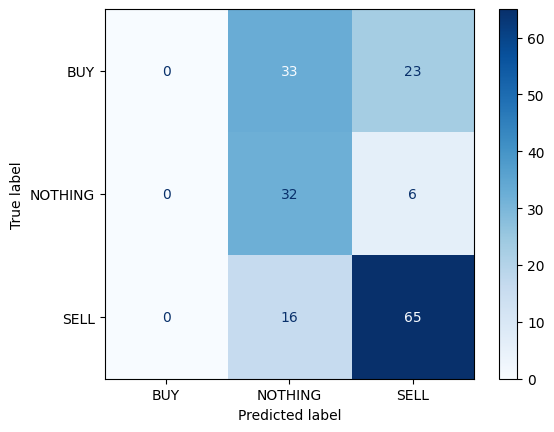

In [153]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true=data["action"], y_pred=model.predict(scaler.transform(data.drop("action", axis=1))),
                                                                  labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.show()